In [1]:
#Some installations will be needed in order to run this code

import numpy as np
import matplotlib.pyplot as plt
import json


import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #Package for handling geospatial data
from shapely.geometry import shape
from shapely import wkt  #The geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
from shapely.geometry import LineString


import requests
import geojson
from pyproj import CRS
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService

# Montreal data

Data access:
https://open.canada.ca/data/en/dataset/77f30d2b-c786-45f0-9f33-ebdef46f3b4c
https://www.donneesquebec.ca/recherche/dataset/vmtl-trajets-individuels-velo-enregistre-mon-resovelo


Articles using the data:
https://www.sciencedirect.com/science/article/pii/S1361920916300736#s0060
https://www.sciencedirect.com/science/article/pii/S0001457516304328


Other resources that might be interesting:
https://pdxscholar.library.pdx.edu/usp_fac/28/

First we read the CSV-files into a Panda dataframes (df)

In [2]:
#Read data into panda
df = pd.read_json(r"Stadradeln_Movebis/trip5000.json")


Below we 
   1. Use the GeoPandas dataframe (gdf) to process the geo-data (contained in the df-column "features");
   2. Set the crs (Coordinate Reference System - lets Python know how the coordinates relates to places on earth)
   3. Plot all the routes (just for fun)
   4. split all the routes into points (*)

(*) explanation further down

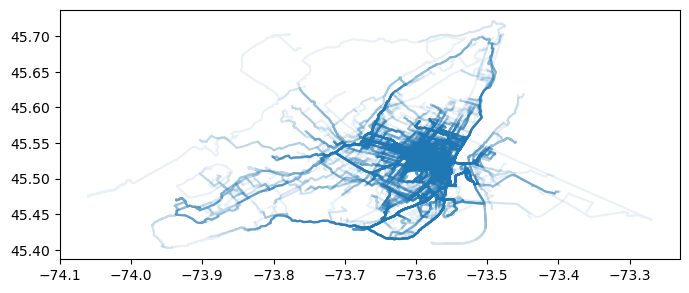

In [3]:
#Read the data as a geodataframe
gdf = gpd.GeoDataFrame.from_features(df["features"])
gdf = gdf.set_crs('epsg:3979') 
gdf.plot(alpha=0.1,figsize=(8, 8))

#Create a list of points from linestring
gdf['points'] = gdf.apply(lambda x: [y for y in x['geometry'].coords], axis=1)

We do some clean up, as well as determine the duration of each trip

In [4]:
df["duration_s"] = (gdf['stop'].apply(pd.to_datetime) - gdf['start'].apply(pd.to_datetime)) / pd.Timedelta(seconds=1)
df = df.drop("type", axis=1)
df = df.drop("name", axis=1)
df = df.drop("features", axis=1)
df["length"] = gdf["length"]
df["n_coord"] = gdf["n_coord"]
df["time_per_seg"] = df["duration_s"]/df["n_coord"]

(*) here comes the explanation for why we split all routes into points;
in gdf each row represents a trip, and it's associated geometry is a LineString:

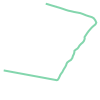

In [5]:
#lets look at the last trip:
gdf["geometry"][4880]

In [6]:
gdf

,geometry,stop,id_origine,start,length,purpose,liste_segments_jsonb,n_coord,id,points
0,"LINESTRING (-73.577 45.507, -73.578 45.507, -7...",2013-06-25 16:34:16,52,2013-06-25 16:21:21,3163,Commute,"[{'source': 'GEOBASE', 'id': 1260962}, {'sourc...",511,52,"[(-73.577476909289, 45.5069002299392), (-73.57..."
1,"LINESTRING (-73.629 45.464, -73.629 45.464, -7...",2013-07-25 14:40:06,2325,2013-07-25 14:37:42,1066,Courses,"[{'source': 'GEOBASE', 'id': 1310311}, {'sourc...",196,2325,"[(-73.62896982707571, 45.4637247074939), (-73...."
2,"LINESTRING (-73.585 45.568, -73.582 45.566, -7...",2013-07-25 14:43:12,2326,2013-07-25 14:19:15,5619,Courses,"[{'source': 'GEOBASE', 'id': 1170061}, {'sourc...",1036,2326,"[(-73.5848059077338, 45.5678560254651), (-73.5..."
3,"LINESTRING (-73.577 45.507, -73.577 45.507, -7...",2013-06-25 16:34:16,53,2013-06-25 16:21:20,3115,Commute,"[{'source': 'GEOBASE', 'id': 1260962}, {'sourc...",1403,53,"[(-73.577476909289, 45.5069002299392), (-73.57..."
4,"LINESTRING (-73.605 45.519, -73.605 45.519, -7...",2013-06-26 13:00:05,56,2013-06-26 12:46:01,5376,Domicile-travail,"[{'source': 'RES_CYCL_2015', 'id': 4263}, {'so...",1004,56,"[(-73.6050191016393, 45.5190269268572), (-73.6..."
...,...,...,...,...,...,...,...,...,...,...
4876,"LINESTRING (-73.618 45.537, -73.618 45.537, -7...",2015-07-04 17:19:31,28853,2015-07-04 17:10:45,1982,other,"[{'source': 'RES_CYCL_2015', 'id': 6153}, {'so...",321,28853,"[(-73.6184145805443, 45.5372718484803), (-73.6..."
4877,"LINESTRING (-73.666 45.548, -73.666 45.548, -7...",2015-08-29 17:33:39,28859,2015-08-29 17:28:11,1456,Travail,"[{'source': 'GEOBASE', 'id': 1030060}, {'sourc...",460,28859,"[(-73.6661455969195, 45.5478216011154), (-73.6..."
4878,"LINESTRING (-73.582 45.526, -73.581 45.526, -7...",2015-08-30 16:16:31,28893,2015-08-30 15:40:30,1853,Magasinage,"[{'source': 'GEOBASE', 'id': 1220171}, {'sourc...",433,28893,"[(-73.5815068424736, 45.525552748198), (-73.58..."
4879,"LINESTRING (-73.571 45.521, -73.571 45.521, -7...",2015-08-30 19:52:47,28904,2015-08-30 19:35:18,1521,Magasinage,"[{'source': 'GEOBASE', 'id': 1220269}, {'sourc...",441,28904,"[(-73.5713181155625, 45.5206059271331), (-73.5..."


In [7]:
#The geometry is all points on the route after each other
print("OG one string: ", gdf["geometry"][4880])
#and we are interested in each segment of the route separately
print("\nNEW list of points: ", gdf["points"][4880])

OG one string:  LINESTRING (-73.5453271126079 45.5442862242972, -73.5448485725921 45.544144444276, -73.5448398907 45.5441424670019, -73.5447522999 45.5441158126019, -73.5446478613 45.5440814468019, -73.5445427523 45.5440439796019, -73.5444353801 45.5440117931019, -73.5443337914 45.5439917185019, -73.5442216416 45.5439641001019, -73.5441039596 45.5439426844019, -73.5439783149 45.5439188378019, -73.5439203121 45.5438985117019, -73.5438619741 45.5438773474019, -73.543805061 45.5438535428019, -73.5437483155 45.5438305764019, -73.5436348245 45.5437936122019, -73.5435270332 45.5437620543019, -73.5434528534 45.5437179655019, -73.5433945992 45.5436404748019, -73.5433723871 45.5435942905019, -73.5433522706 45.5435461365019, -73.5433868878 45.5434768182019, -73.543471545 45.5434076675019, -73.5435168073 45.543367057101904, -73.5435556994 45.5433261116019, -73.5435895622 45.5432866328019, -73.5436510854 45.5432152190019, -73.5437000357 45.5431487505019, -73.5437421129 45.5430851318019, -73.543810

<AxesSubplot:>

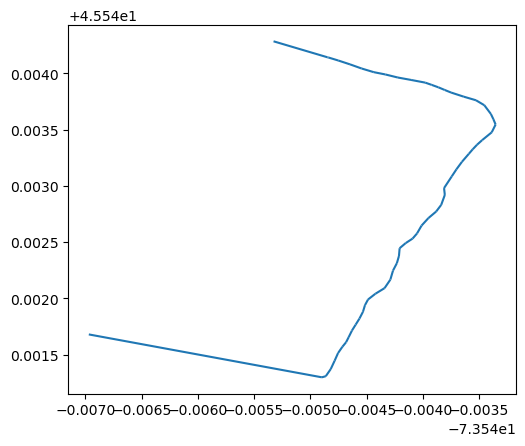

In [8]:
#Now we turn it into segments: (This is how I got it to work, probably some easier way)

trip = 4880 #index of trip

#create two lists with coordinates shifted one idx in second list,
#so that they line up and instead of having points [(x1,y1), (x2,y2), (x3,y3)]
#we will have line segments:    a          b
#                            (x1,y1) -> (x2,y2)
#                            (x2,y2) -> (x3,y3)
k = len(gdf["points"][trip])
a = gdf["points"][trip][0:k-1]
b = gdf["points"][trip][1:k]
df_a = pd.DataFrame(a, columns=["long1", "lat1"])
df_b = pd.DataFrame(b, columns=["long2", "lat2"])
test_df = pd.concat([df_a, df_b], axis=1)

#create linestrings of the lines a -> b
series = test_df.apply(
    lambda r: LineString([
         (r['long1'], r['lat1']),
         (r['long2'], r['lat2'])
    ]),
    axis=1
)
#convert from series to dataframe
s = pd.Series(series, name="geo")
#convert from df to geo-df
one_trip_gdf = gpd.GeoDataFrame(s, geometry='geo')





#it looks exactly the same
one_trip_gdf.plot()

In [13]:
#but the data is split up into segments
print(one_trip_gdf.head())


                                                 geo     length
0  LINESTRING (-73.54533 45.54429, -73.54485 45.5...  55.497534
1  LINESTRING (-73.54485 45.54414, -73.54484 45.5...   0.990102
2  LINESTRING (-73.54484 45.54414, -73.54475 45.5...  10.180626
3  LINESTRING (-73.54475 45.54412, -73.54465 45.5...  12.225592
4  LINESTRING (-73.54465 45.54408, -73.54454 45.5...  12.407925
60


In [10]:
#Which means we can apply geopandas functions to the data:

#Add length of each short segment
R_earth = 6371*1000   # earth radius [m]
d2r = np.pi/180
one_trip_gdf["length"] = one_trip_gdf["geo"].length* d2r * R_earth

In [14]:
#add time to each short segment (this SHOULD be taken from OG timestamps, but currently not available)


time_per_segment = df["duration_s"][trip]/k

time = []
for i in range(len(one_trip_gdf)):
    time.append(time_per_segment)
    #time.append(1)
    
df_time = pd.DataFrame(time, columns=["time"])

one_trip_gdf["time"] = df_time["time"]


#Calculate (and add) velocity for each segment
one_trip_gdf["vel"] = one_trip_gdf["length"]/one_trip_gdf["time"]


In [15]:
print(one_trip_gdf.head())

                                                 geo     length  time  \
0  LINESTRING (-73.54533 45.54429, -73.54485 45.5...  55.497534   1.7   
1  LINESTRING (-73.54485 45.54414, -73.54484 45.5...   0.990102   1.7   
2  LINESTRING (-73.54484 45.54414, -73.54475 45.5...  10.180626   1.7   
3  LINESTRING (-73.54475 45.54412, -73.54465 45.5...  12.225592   1.7   
4  LINESTRING (-73.54465 45.54408, -73.54454 45.5...  12.407925   1.7   

         vel  
0  32.645608  
1   0.582413  
2   5.988603  
3   7.191525  
4   7.298780  


Text(0, 0.5, 'speed [m/s]')

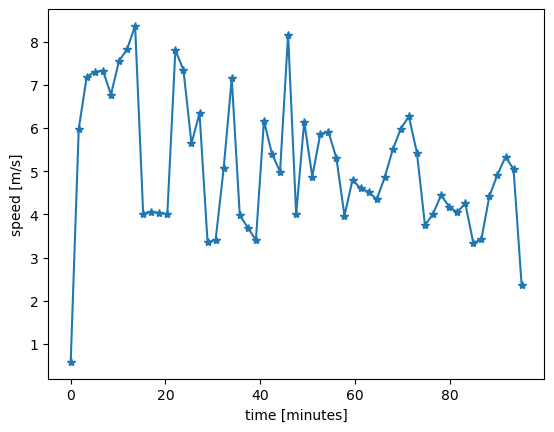

In [16]:
t = 0
x = [t]
y = []
for i in range(len(one_trip_gdf["time"])):
    if one_trip_gdf["vel"][i] <= 20:
        t = t + one_trip_gdf["time"][i]
        x.append(t)
        y.append(one_trip_gdf["vel"][i])
x.pop()
plt.plot(x, y, "*-")
plt.xlabel("time [minutes]")
plt.ylabel("speed [m/s]")

Now we can do the same to all trips

In [17]:
R_earth = 6371*1000   # earth radius [m]
d2r = np.pi/180


time = [] # time_per_segment for each segment
A = [] # (long1, lat1)
B = [] # (long2, lat2)
og_trip = [] #which trip does the segment belong to

for i in range(len(gdf)):
    trip = i #index of trip

    #create two lists with coordinates shifted one idx in second list,
    #so that they line up and instead of having points ((x1,y1), (x2,y2), (x3,y3)) 
    #we will have line segments:    a          b
    #                            (x1,y1) -> (x2,y2)
    #                            (x2,y2) -> (x3,y3)
    k = len(gdf["points"][trip])
    a = gdf["points"][trip][0:k-1]
    b = gdf["points"][trip][1:k]
    time_per_segment = df["duration_s"][trip]/k #again want og data w/ time-stamps, also check if n_coord == # of coord
    t = [time_per_segment for x in range(k-1)]
    og = [trip for x in range(k-1)]
    
    A += a
    B += b
    time += t
    og_trip += og


In [18]:
df_a = pd.DataFrame(A, columns=["long1", "lat1"])
df_b = pd.DataFrame(B, columns=["long2", "lat2"])
test_df = pd.concat([df_a, df_b], axis=1)

#create linestrings of the lines a -> b
series = test_df.apply(
    lambda r: LineString([
         (r['long1'], r['lat1']),
         (r['long2'], r['lat2'])
    ]),
    axis=1
)
#convert from series to dataframe
s = pd.Series(series, name="geo")

#convert from df to geo-df
trip_gdf = gpd.GeoDataFrame(s, geometry='geo')

#Add columns
trip_gdf["time"] = time
trip_gdf["og_trip"] = og_trip
trip_gdf["length"] = trip_gdf["geo"].length* d2r * R_earth
trip_gdf["vel"] = trip_gdf["length"]/trip_gdf["time"]

In [22]:
trip_gdf

,geo,time,og_trip,length,vel
0,"LINESTRING (-73.57748 45.50690, -73.57751 45.5...",1.89951,0,4.164946,2.192643
1,"LINESTRING (-73.57751 45.50692, -73.57757 45.5...",1.89951,0,12.379816,6.517374
2,"LINESTRING (-73.57757 45.50701, -73.57774 45.5...",1.89951,0,19.563040,10.298994
3,"LINESTRING (-73.57774 45.50705, -73.57792 45.5...",1.89951,0,25.352687,13.346963
4,"LINESTRING (-73.57792 45.50718, -73.57810 45.5...",1.89951,0,22.608693,11.902383
...,...,...,...,...,...
4327028,"LINESTRING (-73.54475 45.54151, -73.54478 45.5...",1.70000,4880,8.365083,4.920637
4327029,"LINESTRING (-73.54478 45.54145, -73.54482 45.5...",1.70000,4880,9.064658,5.332152
4327030,"LINESTRING (-73.54482 45.54137, -73.54486 45.5...",1.70000,4880,8.582314,5.048420
4327031,"LINESTRING (-73.54486 45.54131, -73.54490 45.5...",1.70000,4880,4.029712,2.370419


In [24]:
df_save = pd.DataFrame(trip_gdf.drop(columns='geo'))

In [26]:
df_save.rename(columns = {'og_trip':'trip_id'}, inplace = True)

In [16]:
# make some cuts?
gdf_no_cuts = trip_gdf

trip_gdf = trip_gdf.drop(trip_gdf[trip_gdf["vel"] >= 20].index)

In [36]:
#Here we simply set the bin-sizes for the average speed
M_var = "vel"  
M_group_name = "bin_01_ms"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/10)
bin_edges.append(np.inf)

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(0,201):
    bin_labels.append(k)


# This part does the grouping based on the input above
df_save[M_group_name] = pd.cut(
    df_save[M_var],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e. a row is now given by: edge(geometry, duration, visitors, speed_BIN)

In [37]:
#We can aggregate the data in different ways
M_aggr = {
    "vel": "count",  #"geometry" is used here to calculate how many rows of data are in each category
}

# Renaming of "geometry" in aggregation since it is only (arbitrarily) used for counting the number of rows
M_rename = {"vel": "Count"}

# Do the aggregation and renamning
M_histo = (
    df_save.groupby(M_group_name).agg(M_aggr).rename(columns=M_rename)
)

# Display the aggregated data
#print(M_histo)

In [38]:
print(df_save)

            time  trip_id      length         vel bin_01_ms
0        1.89951        0    4.164946    2.192643       2.2
1        1.89951        0   12.379816    6.517374       6.6
2        1.89951        0   19.563040   10.298994      10.3
3        1.89951        0   25.352687   13.346963      13.4
4        1.89951        0   22.608693   11.902383      12.0
...          ...      ...         ...         ...       ...
4327028  1.70000     4880    8.365083    4.920637       5.0
4327029  1.70000     4880    9.064658    5.332152       5.4
4327030  1.70000     4880    8.582314    5.048420       5.1
4327031  1.70000     4880    4.029712    2.370419       2.4
4327032  1.70000     4880  234.331246  137.841910    > 20.0

[4327033 rows x 5 columns]


In [39]:
df_save.to_csv("Montreal_all.csv", index=False)

NameError: name 'df_save' is not defined

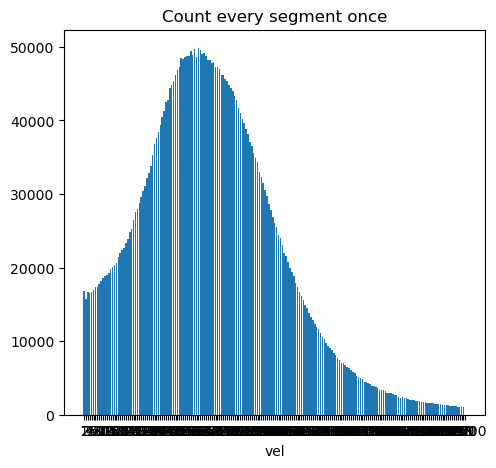

In [19]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel("vel")
plt.bar(M_histo.index, M_histo["Count"])
plt.title("Count every segment once")

plt.show()

# Comparison to Stadradeln


In [20]:
df_SR = pd.read_csv(r"Stadradeln_Movebis/18to20_one_visit.csv")

In [21]:
#clean up
df_SR = df_SR.drop(df_SR[df_SR["av_speed_ms"] >= 20].index)

In [22]:
df_SR

,geometry,av_speed_ms,visits,length,duration,total_duration
0,"LINESTRING (13.3373399 49.0600527, 13.3381247 ...",2.268807,1,91.366416,40.270690,40.270690
1,"LINESTRING (13.3381247 49.0598093, 13.3373399 ...",6.184439,1,91.366416,14.773598,14.773598
2,"LINESTRING (13.3365226 49.0602214, 13.3357427 ...",8.091433,1,87.137119,10.769058,10.769058
3,"LINESTRING (13.3357427 49.0602979, 13.3365226 ...",2.482184,1,87.137119,35.105026,35.105026
4,"LINESTRING (13.3365226 49.0602214, 13.3368261 ...",2.397976,1,34.239417,14.278463,14.278463
...,...,...,...,...,...,...
21808177,"LINESTRING (8.38640670000001 55.0360898, 8.386...",2.621129,1,6.163379,2.351422,2.351422
21808178,"LINESTRING (8.38643640000001 55.036043, 8.3864...",2.665524,1,7.874305,2.954130,2.954130
21808179,"LINESTRING (8.38648799999999 55.0359945, 8.386...",3.380406,1,7.517673,2.223896,2.223896
21808180,"LINESTRING (8.3865242 55.0359374, 8.3866935000...",4.672642,1,21.718407,4.647993,4.647993


In [23]:
#Here we simply set the bin-sizes for the average speed
SR_var = "av_speed_ms"  
SR_group_name = "vel_ms"

#set the edges of the bins
bin_edges = [-np.inf]
for i in range(1,201):
    bin_edges.append(i/10)
bin_edges.append(np.inf)

#name the bins (should be one less than bin_edges)
bin_labels = []
for k in range(1,201):
    bin_labels.append(str(k))

bin_labels.append("> " + str(k))


# This part does the grouping based on the input above
df_SR[SR_group_name] = pd.cut(
    df_SR[SR_var],
    bins=bin_edges,
    labels=bin_labels,
    right=True)  # Wheter to include the right edge in group or not

#We have now created an additional column which denotes which of the above bins each row belongs to
#i.e. a row is now given by: edge(geometry, duration, visitors, speed_BIN)

In [26]:
#We can aggregate the data in different ways
SR_aggr = {
    "geometry": "count",  #"geometry" is used here to calculate how many rows of data are in each category
    "duration": "sum", #If we want to aggregate based on duration
}

# Renaming of "geometry" in aggregation since it is only (arbitrarily) used for counting the number of rows
SR_rename = {"geometry": "Count"}

# Do the aggregation and renamning
SR_histo = (
    df_SR.groupby(SR_group_name).agg(SR_aggr).rename(columns=SR_rename)
)

# Display the aggregated data
print(SR_histo)

        Count      duration
vel_ms                     
1       61729           NaN
2       39551  8.036732e+06
3       41959  5.206467e+06
4       42004  3.859921e+06
5       41535  3.046874e+06
...       ...           ...
197       170  5.109688e+02
198       174  5.291133e+02
199       138  3.711555e+02
200       160  4.414704e+02
> 200       0  0.000000e+00

[201 rows x 2 columns]


In [27]:
SR_histo = SR_histo.dropna() #drop NaN-values

In [28]:
M_histo["scaled_count"] = M_histo["Count"]/sum(M_histo["Count"])

SR_histo["scaled_count"] = SR_histo["Count"]/sum(SR_histo["Count"])
SR_histo["scaled_duration"] = SR_histo["duration"]/sum(SR_histo["duration"])


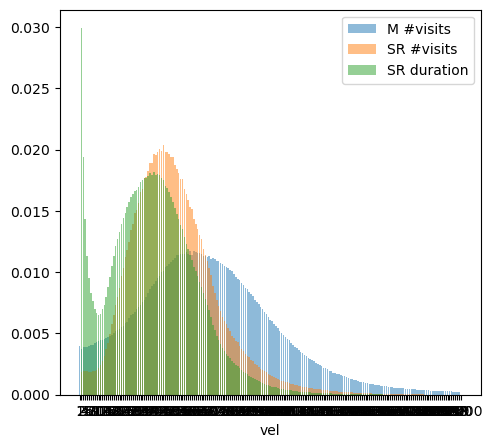

In [29]:
fig = plt.figure(figsize=(25, 5))

plt.subplot(141)
plt.xlabel("vel")
plt.bar(M_histo.index, M_histo["scaled_count"], alpha=0.5)
plt.bar(SR_histo.index, SR_histo["scaled_count"], alpha=0.5)
plt.bar(SR_histo.index, SR_histo["scaled_duration"], alpha=0.5)
plt.legend(["M #visits", "SR #visits", "SR duration"])
plt.title("")

#plt.subplot(142)
#plt.xlabel("vel")
#plt.bar(comp1.index, comp1["scaled"], alpha=0.5)
#plt.bar(comp2.index, comp2["scale_duration"], alpha=0.5)
#plt.title("Count every row once")


plt.show()

# 26 june ^

# New SR data

In [ ]:
sr2 = pd.

# Elevation

Still testing

How to read WCS:
https://owslib.readthedocs.io/en/latest/usage.html#wcs 
https://python-gis-book.readthedocs.io/en/latest/part2/chapter-09/nb/01-retrieving-data-from-wfs.html
https://pavics-sdi.readthedocs.io/en/latest/notebooks/WCS_example.html


Dataset:
https://open.canada.ca/data/en/dataset/0fe65119-e96e-4a57-8bfe-9d9245fba06b

The specific XML-file:
https://datacube.services.geo.ca/ows/elevation?service=wcs&request=GetCapabilities


In [ ]:
https://cloudstore.zih.tu-dresden.de/index.php/s/JQ5656QWgQj2ctN/download/Abgabe_Fluidtronik_RadVerS_Anno_Ausschnitt_Albertplatz_Fritz_Foerster_Platz.gpkg

In [227]:
#Montreal


wcs = WebCoverageService("https://datacube.services.geo.ca/ows/elevation", version="1.1.1")

/Users/johannaskantorp/opt/anaconda3/lib/python3.9/site-packages/owslib/coverage/wcs110.py:85: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  elem = self._capabilities.find(self.ns.OWS('ServiceProvider')) or self._capabilities.find(self.ns.OWS('ServiceProvider'))  # noqa


In [228]:
list(wcs.contents)

['dsm', 'dtm', 'dsm-slope', 'dsm-aspect', 'dtm-slope', 'dtm-aspect']

In [232]:
wcs.contents.keys()

dict_keys(['dsm', 'dtm', 'dsm-slope', 'dsm-aspect', 'dtm-slope', 'dtm-aspect'])

In [229]:
print([op.name for op in wms.operations])

['GetCapabilities', 'GetMap', 'GetFeatureInfo']


In [237]:
wcs.contents['dsm-aspect']

In [231]:
#wms.getOperationByName('GetFeatureInfo').methods
wms.getOperationByName('GetCapabilities').methods
#wms.getOperationByName('GetFeatureInfo').formatOptions
#wms.getOperationByName('GetCapabilities').formatOptions

[{'type': 'Get', 'url': 'https://datacube.services.geo.ca/ows/elevation'}]

In [208]:


wms = WebMapService("https://datacube.services.geo.ca/ows/elevation", version="1.3.0")



In [222]:
list(wms.contents)
#print([op.name for op in wms.operations])

['dsm',
 'dsm-hillshade',
 'dtm',
 'dtm-hillshade',
 'dsm-slope',
 'dsm-aspect',
 'dtm-slope',
 'dtm-aspect']

In [221]:
#wms.getOperationByName('GetFeatureInfo').methods
#wms.getOperationByName('GetCapabilities').methods
wms.getOperationByName('GetFeatureInfo').formatOptions
#wms.getOperationByName('GetCapabilities').formatOptions

['text/xml', 'application/json']

In [199]:
#Example of how to import WFS



# Specify the url for the backend.
# Here we are using data from Statistics Finland: https://www.stat.fi/org/avoindata/paikkatietoaineistot_en.html. (CC BY 4.0)
url = "http://geo.stat.fi/geoserver/tilastointialueet/wfs"

# Specify parameters (read data in json format).
params = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="tilastointialueet:kunta4500k",
    outputFormat="json",
)

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson and set coordinate reference system
data = gpd.GeoDataFrame.from_features(geojson.loads(r.content), crs="EPSG:3067")


Not really sure whay noeud is, hoping it might contain geo-data on Montreal.

In [ ]:
nodes = pd.read_csv(
    r"Stadradeln_Movebis/noeud.csv",
    sep=",")


#EPSG : 3979     gdf = gdf.set_crs('epsg:3979')

nodes["GEOMETRY"] = gpd.GeoSeries.from_wkt(nodes["GEOMETRY"]) 

nodes_geo = gpd.GeoDataFrame(nodes, geometry='GEOMETRY')  #Create geospatial dataframe in geopanda

print(nodes_geo.crs)

nodes_geo.plot(figsize=(8, 8))

In [ ]:
R_earth = 6371*1000   # earth radius [m]
d2r = np.pi/180

t = 0
x = [t]
y = []
trip_cut = []
count = 0

for i in range(2):
    trip = i #index of trip

    #create two lists with coordinates shifted one idx in second list,
    #so that they line up and instead of having points ((x1,y1), (x2,y2), (x3,y3)) 
    #we will have line segments:    a          b
    #                            (x1,y1) -> (x2,y2)
    #                            (x2,y2) -> (x3,y3)
    k = len(gdf["points"][trip])
    a = gdf["points"][trip][0:k-1]
    b = gdf["points"][trip][1:k]
    df_a = pd.DataFrame(a, columns=["long1", "lat1"])
    df_b = pd.DataFrame(b, columns=["long2", "lat2"])
    test_df = pd.concat([df_a, df_b], axis=1)

    #create linestrings of the lines a -> b
    series = test_df.apply(
        lambda r: LineString([
             (r['long1'], r['lat1']),
             (r['long2'], r['lat2'])
        ]),
        axis=1
    )
    #convert from series to dataframe
    s = pd.Series(series, name="geo")
    #convert from df to geo-df
    trip_gdf = gpd.GeoDataFrame(s, geometry='geo')


    #Add length of each short segment
    trip_gdf["length"] = trip_gdf["geo"].length* d2r * R_earth

    #add time to each short segment
    #total_time = df["duration_s"][trip]
    #num_of_seg = len(trip_gdf["length"])
    #time_per_segment = total_time/num_of_seg
    time_per_segment = df["time_per_obs"][trip]

    time = []
    for i in range(len(trip_gdf)):
        time.append(time_per_segment)
        #time.append(1)

    df_time = pd.DataFrame(time, columns=["time"])

    trip_gdf["time"] = df_time["time"]

    trip_gdf["vel"] = trip_gdf["length"]/trip_gdf["time"]



    for i in range(len(trip_gdf["time"])):
        if trip_gdf["vel"][i] <= 20:
            t = t + trip_gdf["time"][i]
            x.append(t)
            y.append(trip_gdf["vel"][i])
        else:
            count += 1

    trip_cut.append(t)
        

        
        
        
        
x.pop()



plt.plot(x, y)
for xc in trip_cut:
    plt.axvline(x=xc, color="r", alpha=0.1)

NameError: name 'np' is not defined